In [1]:
from data.sampling import simple_sample, pair_sample
from models.velocity import VelocityMLP
from training import train_flow_matching
from inference import compare_inference, ode_backward
import torch
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
%load_ext autoreload
%autoreload 2

# 1. Train a Teacher flow model

## Specify a data distribution with classes

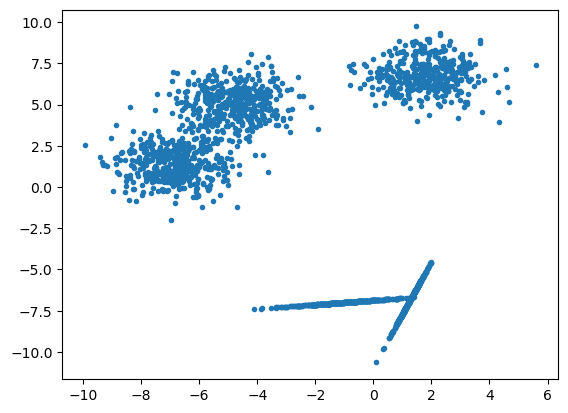

In [5]:
# Specific the data distribution
# C: number of classes, 
# N: number of dimensions of ambient space
C, N = 5, 2
sampler = simple_sample(C, N, dims=[2,2,1,1,2])


# Quick sanity check sample on the chosen device and plot the samples
x0, c = sampler(2048, device=device, class_idx = None)
x0 = x0.detach().cpu().numpy()
plt.plot(x0[:, 0], x0[:, 1], '.')
plt.show()

In [14]:
sampler_eg1 = sampler

## Train a conditional velocity to learn this distribution

In [6]:
# Model and training
model = VelocityMLP(num_classes=C, dim=N, hidden_dim=256, num_layers=4).to(device)
losses = train_flow_matching(
    model,
    sampler,
    num_steps=10000,
    batch_size=128,
    drop_label_prob=0.1,
    device=device,
)


step 100/10000 loss 4.015725
step 200/10000 loss 2.452491
step 300/10000 loss 3.586475
step 400/10000 loss 3.551149
step 500/10000 loss 2.612487
step 600/10000 loss 2.275239
step 700/10000 loss 2.941035
step 800/10000 loss 2.698943
step 900/10000 loss 2.345985
step 1000/10000 loss 2.253434
step 1100/10000 loss 2.437859
step 1200/10000 loss 2.551656
step 1300/10000 loss 2.222800
step 1400/10000 loss 3.022395
step 1500/10000 loss 1.711720
step 1600/10000 loss 2.828945
step 1700/10000 loss 2.557828
step 1800/10000 loss 2.320090
step 1900/10000 loss 2.136388
step 2000/10000 loss 2.531292
step 2100/10000 loss 1.927878
step 2200/10000 loss 3.125621
step 2300/10000 loss 2.709986
step 2400/10000 loss 2.816879
step 2500/10000 loss 2.126628
step 2600/10000 loss 1.930425
step 2700/10000 loss 2.167771
step 2800/10000 loss 2.254052
step 2900/10000 loss 2.227136
step 3000/10000 loss 1.736297
step 3100/10000 loss 2.400525
step 3200/10000 loss 1.955902
step 3300/10000 loss 1.703469
step 3400/10000 los

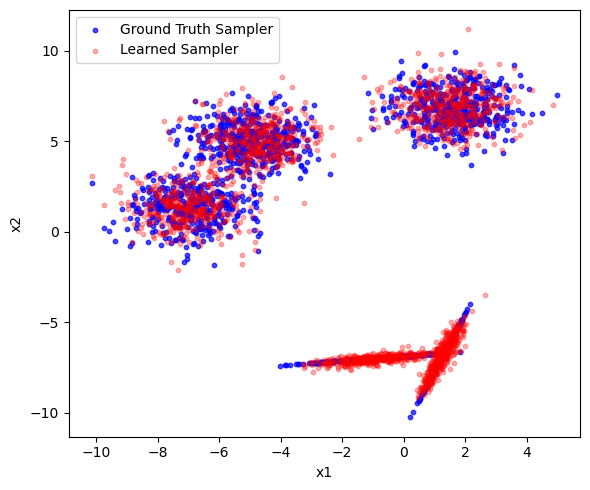

In [22]:
# Inference: K samples, c = int in {0,...,C-1} (one class) or C or None (uniform)
K = 2000
# use c = 0, ..., C-1 for conditional classes; 
# use c = C for unconditional.
# use None for uniform over all classes. (one view for all classes results)
c = None
x0_true, x0_gen = compare_inference(model, T=200, K=K, c=c, sampler=sampler, device=device, guidance=1)

# x0_true 是 (K, N) 的 tensor
x_true = x0_true.detach().cpu().numpy()

# x0_gen 是 (x, c) 的 tuple
x_gen_tensor, c_gen_tensor = x0_gen
x_gen = x_gen_tensor.detach().cpu().numpy()

# Stack: sampler (blue) + inference (red, transparent)
plt.figure(figsize=(6, 5))
plt.scatter(x_gen[:, 0], x_gen[:, 1], s=10, alpha=0.7, c='blue', label='Ground Truth Sampler')
plt.scatter(x_true[:, 0], x_true[:, 1], s=10, alpha=0.3, c='red', label='Learned Sampler')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()

## Algebraically distill the score model and clean-prediction model

With the schedule $\alpha_t = 1-t, \sigma_t = t$, we can directly algebraically distill the score function and "clean prediction" from the pre-trained velocity field $v^*$, given by

$$ s^*(x_t, t, c, g) = \frac{t-1}{t} v^*(x_t, t, \emptyset) - \frac 1 t x_t + g \cdot \frac{t-1}{t} ( v^*(x_t, t, c) - v^*(x_t, t, \emptyset)) $$

$$ x^*(x_t, t, c) = x_t - tv^*(x_t, t, c). $$

In [23]:
from score import CleanPredModel, ScoreModel

# Score and clean prediction (fixed pretrained v)
clean_model = CleanPredModel(model, guidance = 1)
score_model = ScoreModel(model)

A step path experiment.

Given a total $T$ steps, I first denoise Euler $T_v$ steps, then go one step backward to clean using ```clean_model```.

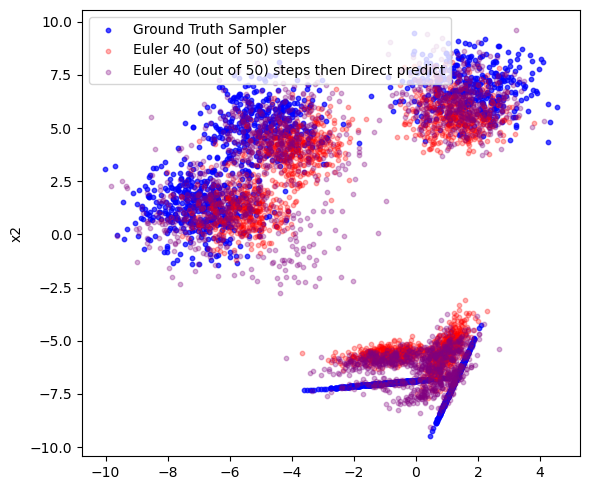

In [24]:
T = 50
T_v = 40
K = 2000
c = None

t_clean = 1 - T_v / T

xt_s = ode_backward(model, T=T, K=K, c=c, device=device, guidance=1, steps = T_v)
x0_s = clean_model(xt_s, t_clean, c)
x0, c = sampler(K, device=device, class_idx = c)

xt_s = xt_s.detach().cpu().numpy()
x0 = x0.detach().cpu().numpy()
x0_s = x0_s.detach().cpu().numpy()

plt.figure(figsize=(6, 5))
plt.scatter(x0[:, 0], x0[:, 1], s=10, alpha=0.7, c='blue', label='Ground Truth Sampler')
plt.scatter(xt_s[:, 0], xt_s[:, 1], s=10, alpha=0.3, c='red', label=f'Euler {T_v} (out of {T}) steps')
plt.scatter(x0_s[:, 0], x0_s[:, 1], s=10, alpha=0.3, c='purple', label=f'Euler {T_v} (out of {T}) steps then Direct predict')
plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()


# 2. Distill the teacher model to a student model using distillation

**DMD distillation — step-by-step**

1. **Options**: (alignment a, guidance augment g); Mgen (generator steps per iteration); Mvel (velocity steps per iteration); Iter = 100.

2. **Phase 0 — One-step generator G_θ(z, c)**  
   Use the clean-prediction model x(z, 1, c) as a surrogate. Define a small MLP G_θ(z, c) and regress:
   ‖G_θ(z, c) − x(z, 1, c)‖² for e.g. 1000 steps (z ∼ N(0,I), c ∼ p(C)).

3. **Phase 1 (each iteration) — Train student velocity v_φ**  
   Freeze θ. Sample c ∼ p(C), z ∼ N(0,I), compute x0 = G_θ(z,c), then draw ε ∼ N(0,I) independently. Train v_φ(x_t, t, c) for Mvel steps using fresh samples from G_θ each step.

4. **Phase 2 (each iteration) — Distill score and update G_θ**  
   Freeze φ. Build s_φ from v_φ. Update θ for Mgen steps using the IKL gradient:
   E[(a(s_φ − s) + (1−g)(s − s_∅)) · (1−t) · ∂G_θ/∂θ] with x_t = G_θ(z,c), t ∼ U[0.01, 0.99].

5. **Loop**: Repeat Phase 1 and Phase 2 for Iter iterations (θ, φ, θ, φ, …).

### 2.1 Initiate a student model G_theta to match against the distilled clean_prediction model.

In [81]:
# Phase 0: Warm-up distillation of G_theta from the wrapped teacher's clean-prediction model
from models.onestep import OneStepGenerator
from distillation import train_generator_regression


# Define a small one-step generator G_theta(z, c)
G_theta = OneStepGenerator(num_classes=C, dim=N, hidden_dim=64, num_layers=3, embed_dim=32).to(device)

# Regress G_theta(z, c) to the teacher clean prediction x(z, 1, c)
reg_steps = 2000
batch_size = 128
reg_losses = train_generator_regression(
    G=G_theta,
    clean_model=clean_model,
    num_steps=reg_steps,
    batch_size=batch_size,
    C=C,
    N=N,
    lr=1e-3,
    device=device,
    verbose=True,
)

  [G reg] step 100/2000 loss 0.025539
  [G reg] step 200/2000 loss 0.005225
  [G reg] step 300/2000 loss 0.003372
  [G reg] step 400/2000 loss 0.005236
  [G reg] step 500/2000 loss 0.001493
  [G reg] step 600/2000 loss 0.003230
  [G reg] step 700/2000 loss 0.001364
  [G reg] step 800/2000 loss 0.002182
  [G reg] step 900/2000 loss 0.001757
  [G reg] step 1000/2000 loss 0.002499
  [G reg] step 1100/2000 loss 0.001465
  [G reg] step 1200/2000 loss 0.001011
  [G reg] step 1300/2000 loss 0.005487
  [G reg] step 1400/2000 loss 0.005630
  [G reg] step 1500/2000 loss 0.001195
  [G reg] step 1600/2000 loss 0.001952
  [G reg] step 1700/2000 loss 0.002286
  [G reg] step 1800/2000 loss 0.001358
  [G reg] step 1900/2000 loss 0.001125
  [G reg] step 2000/2000 loss 0.001777


Plot the warmed-up student result against the actual one-step clean teacher predictor.

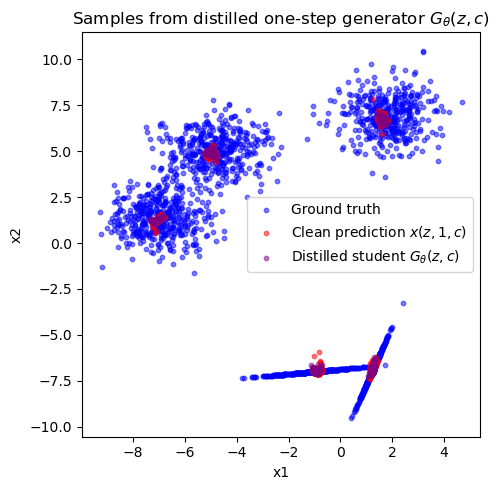

In [82]:
K = 2000  
c = None

z = torch.randn(K, N, device=device)     
if c == None:
    c = torch.randint(0, C, (K,), device=device)  
else:
    c = torch.full((K,), c, device=device)

# 通过一步生成器得到样本
x_stud = G_theta(z, c).detach().cpu().numpy()
x_teac = clean_model(z, 1, c).detach().cpu().numpy()
x_true, c = sampler(K, device=device, class_idx = c)
x_true = x_true.detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(x_true[:, 0], x_true[:, 1], s=10, alpha=0.5, label = 'Ground truth', color = 'blue')
plt.scatter(x_teac[:, 0], x_teac[:, 1], s=10, alpha=0.5, label = 'Clean prediction $x(z, 1, c)$', color = 'red')
plt.scatter(x_stud[:, 0], x_stud[:, 1], s=10, alpha=0.5, label = 'Distilled student $G_\\theta(z,c)$', color = 'purple')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples from distilled one-step generator $G_\\theta(z, c)$")
plt.legend()
plt.tight_layout()
plt.show()

### 2.2 DMD iterative distillation: alternating $v_\phi$ and $G_\theta$

Now we enter the iterative DMD loop. We alternate:

**Phase 1 — Train student velocity $v_\phi$ (freeze $\theta$, update $\phi$)**
- Each step: sample $c \sim p(C)$, $z \sim \mathcal{N}(0, I_N)$, compute $x_0 = G_\theta(z,c)$ (no grad), draw $\varepsilon \sim \mathcal{N}(0,I_N)$ independently.
- Train $v_\phi(x_t, t, c)$ for $M_\text{vel}$ steps with the flow-matching loss $\|v_\phi(x_t,t,c) - (\varepsilon - x_0)\|^2$.
- Fresh samples from $G_\theta$ every step (no pre-cached data source).

**Phase 2 — Update $G_\theta$ via IKL (freeze $\phi$, update $\theta$)**
- Distill the student score $s_\phi(x_t,t,c) = \frac{t-1}{t}\,v_\phi(x_t,t,c) - \frac{1}{t}\,x_t$.
- Update $\theta$ for $M_\text{gen}$ steps with the approximate IKL gradient:

$$\nabla_\theta L_{\mathrm{IKL}}=\mathbb{E}_{z, \varepsilon, c, t \sim U[0.01, 0.99]}\left[\left( \underbrace{a\left(s_\phi\left(x_t, t, c\right)-s\left(x_t, t, c\right)\right)}_{\Delta^{\text{real - fake}}} + \underbrace{(1-g)\left(s\left(x_t, t, c\right)-s\left(x_t, t, \varnothing\right)\right)}_{\Delta^{\text{real - cfg}}} \right) \cdot(1-t) \cdot \frac{\partial G_\theta}{\partial \theta}\right]$$ 

where $x_0 = G_\theta(z,c)$, $x_t = (1{-}t)\,x_0 + t\,\varepsilon$, $t \sim U[0.01, 0.99]$.

**Loop** Phases 1–2 for `Iter` iterations.

In [84]:
# 2.2a  Create the student velocity v_phi (same architecture, fresh weights)
from distillation import train_velocity_from_generator, train_generator_ikl

v_phi = VelocityMLP(num_classes=C, dim=N, hidden_dim=64, num_layers=3, embed_dim=32).to(device)
score_model_teacher = ScoreModel(model)  # teacher score (from pretrained model)

# DMD options
Mvel = 10000        # velocity steps per iteration
Mgen = 10000        # generator steps per iteration
Iter = 50         # number of alternating iterations
batch_size = 128
a, g = 1.0, 1.0  # alignment = 1, guidance augment = 1
lr_v = 1e-4
lr_G = 1e-5
drop_label_prob = 0.1  # probability of label-dropping in student velocity training

* When fixing the $G_\theta$ and distilling a vector field model $v_\phi$ the result looks fine.  
* But when fixing vector field $v_\phi$ and updating $G_\theta$ and learned distribution begins to drift...


=== DMD Iteration 1/50 ===
  Phase 1: Train v_phi (10000 steps, fresh samples from G_theta)
    v_phi loss (last): 0.840806


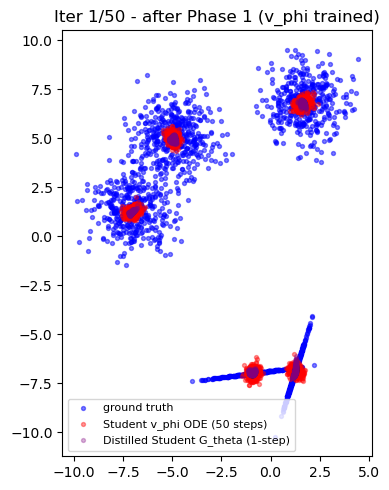

  Phase 2: Update G_theta (10000 steps, a=1.0, g=1.0)


In [ ]:
# 2.2b  DMD iterative loop: alternate Phase 1 (v_phi) and Phase 2 (G_theta)
import gc

K_vis = 2000
T_vis = 50  # ODE steps for v_phi visualization

vel_all_losses = []
ikl_all_gnorms = []

for it in range(Iter):
    print(f"\n=== DMD Iteration {it + 1}/{Iter} ===")

    # --- Phase 1: Freeze one-step student G_theta, update student velocity v_phi for Mvel steps ---
    print(f"  Phase 1: Train v_phi ({Mvel} steps, fresh samples from G_theta)")
    vel_losses = train_velocity_from_generator(
        v_phi, 
        G_theta,
        Mvel=Mvel, 
        batch_size=batch_size, 
        C=C, 
        N=N,
        drop_label_prob=drop_label_prob,
        lr=lr_v, 
        device=device, 
        verbose=False,
    )
    vel_all_losses.extend(vel_losses)
    print(f"    v_phi loss (last): {vel_losses[-1]:.6f}")

    # --- Visualize after Phase 1 ---
    with torch.no_grad():
        x_true, _ = sampler(K_vis, device=device, class_idx=None)
        x_true_np = x_true.cpu().numpy(); del x_true
        x_vphi = ode_backward(v_phi, T=T_vis, K=K_vis, c=None, device=device, guidance=1)
        x_vphi_np = x_vphi.cpu().numpy(); del x_vphi
        z_vis = torch.randn(K_vis, N, device=device)
        c_vis = torch.randint(0, C, (K_vis,), device=device, dtype=torch.long)
        x_Gth = G_theta(z_vis, c_vis)
        x_Gth_np = x_Gth.cpu().numpy(); del x_Gth, z_vis, c_vis
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(x_true_np[:, 0], x_true_np[:, 1], s=8, alpha=0.5, c='blue', label='ground truth')
    ax.scatter(x_vphi_np[:, 0], x_vphi_np[:, 1], s=8, alpha=0.4, c='red', label=f'Student v_phi ODE ({T_vis} steps)')
    ax.scatter(x_Gth_np[:, 0], x_Gth_np[:, 1], s=8, alpha=0.3, c='purple', label='Student G_theta (1-step)')
    ax.legend(fontsize=8)
    ax.set_title(f"Iter {it+1}/{Iter} - after Phase 1 (v_phi trained)")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
    del x_true_np, x_vphi_np, x_Gth_np
    torch.cuda.empty_cache(); gc.collect()
    input("  [Phase 1 done] Press Enter to continue to Phase 2...")
    plt.close(fig); del fig, ax

    # --- Phase 2: Freeze student velocity model v_phi, update one-step student G_theta for Mgen steps ---
    print(f"  Phase 2: Update G_theta ({Mgen} steps, a={a}, g={g})")
    score_model_phi = ScoreModel(v_phi)
    ikl_gnorms = train_generator_ikl(
        G_theta, 
        score_model_phi, 
        score_model_teacher,
        Mgen=Mgen, 
        batch_size=batch_size, 
        C=C, 
        N=N,
        a=a, 
        g=g, 
        lr=lr_G, 
        reweight=True, 
        device=device, 
        verbose=False,
    )
    ikl_all_gnorms.extend(ikl_gnorms)
    print(f"    G_theta IKL grad_norm (last): {ikl_gnorms[-1]:.6f}")

    # --- Visualize after Phase 2 ---
    with torch.no_grad():
        x_true, _ = sampler(K_vis, device=device, class_idx=None)
        x_true_np = x_true.cpu().numpy(); del x_true
        x_vphi = ode_backward(v_phi, T=T_vis, K=K_vis, c=None, device=device, guidance=1)
        x_vphi_np = x_vphi.cpu().numpy(); del x_vphi
        z_vis = torch.randn(K_vis, N, device=device)
        c_vis = torch.randint(0, C, (K_vis,), device=device, dtype=torch.long)
        x_Gth = G_theta(z_vis, c_vis)
        x_Gth_np = x_Gth.cpu().numpy(); del x_Gth, z_vis, c_vis
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(x_true_np[:, 0], x_true_np[:, 1], s=8, alpha=0.5, c='blue', label='ground truth')
    ax.scatter(x_vphi_np[:, 0], x_vphi_np[:, 1], s=8, alpha=0.4, c='red', label=f'Student v_phi ODE ({T_vis} steps)')
    ax.scatter(x_Gth_np[:, 0], x_Gth_np[:, 1], s=8, alpha=0.3, c='purple', label='Student G_theta (1-step)')
    ax.legend(fontsize=8)
    ax.set_title(f"Iter {it+1}/{Iter} - after Phase 1 (v_phi trained)")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
    del x_true_np, x_vphi_np, x_Gth_np
    torch.cuda.empty_cache(); gc.collect()
    input("  [Phase 2 done] Press Enter to continue to next iteration Phase 1...")
    plt.close(fig); del fig, ax

print("\nDMD distillation done.")